## Definitions

In [1]:

input_data_type = 'nostopwords'
train_path = f'../results/bertopic/bertopic_{input_data_type}_data_2022-11-24_14-26-06_train.csv'
test_path = f'../results/bertopic/bertopic_{input_data_type}_data_2022-11-24_14-26-06_test.csv'

results_folder = '../results/bertopic_ncbo/'

In [2]:
UMLS_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HPO', 'ICD10', 'ICD10CM', 'ICD9CM', 'MDR', 'MSH', 'MTH', 'NCBI', 'NCI', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNOMEDCT_US']

# HPO = HP
# MDR = MEDDRA
# MSH = MESH
# MTH = ?
# NCBI = NCBITAXON
# NCI = NCIT
# SNOMEDCT_US = SNMI
UMLS_NCBO_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HP', 'ICD10', 'ICD10CM', 'ICD9CM', 'MEDDRA', 'MESH', 'NCBITAXON', 'NCIT', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNMI']


UMLS_ST21pv_semantic_types_ids = ['T005', 'T007', 'T017', 'T022', 'T031', 'T033', 'T037', 'T038',
'T058', 'T062', 'T074', 'T082', 'T091', 'T092', 'T097', 'T098', 'T103', 'T168', 'T170', 'T201', 'T204']

## Read the data to annotate

In [3]:
def transform_strings_to_arrays(df, col_names = ['tokenized_sentences', 'tokenized_words', 'tokenized_words_processed', 'tokenized_words_no_stopwords']):
    for col in col_names:
        df[col] = df[col].apply(eval)
    return df

In [4]:
import datetime
def get_now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [5]:
import pandas as pd
import re

def read_berttopic_results(path):
    data = pd.read_csv(path, index_col=0)
    data = transform_strings_to_arrays(data, col_names = ['topic_keywords'])
    data['text_to_annotate'] = data.topic_keywords.apply(
        lambda row: re.sub(r"[\'\[\]]", "", str([keyword[0] for keyword in row]))
        )
        
    return data

In [6]:
train_data = read_berttopic_results(train_path)
test_data = read_berttopic_results(test_path)

In [7]:
train_data

,PMID,topic_number,topic_probs,topic_keywords,text_to_annotate
0,25763772,7,0.572430,"[(isolates, 0.05042230174446078), (infection, ...","isolates, infection, infections, transmission,..."
1,25847295,45,1.000000,"[(coumarin, 0.06773487533928456), (antioxidant...","coumarin, antioxidant, pfos, nonylphenol, diet..."
2,26316050,3,0.828241,"[(nanoparticles, 0.039172866449073675), (nps, ...","nanoparticles, nps, silk, films, coatings, sur..."
3,26406200,18,0.837246,"[(muscle, 0.038904659277154356), (walking, 0.0...","muscle, walking, exercise, gait, speed, standi..."
4,26424709,0,0.801365,"[(health, 0.027007069710077814), (students, 0....","health, students, study, participants, mental,..."
...,...,...,...,...,...
3508,28549399,0,0.807432,"[(health, 0.027007069710077814), (students, 0....","health, students, study, participants, mental,..."
3509,28549760,6,1.000000,"[(diabetes, 0.0369171787521816), (obesity, 0.0...","diabetes, obesity, intake, bmi, metabolic, adu..."
3510,28550154,3,1.000000,"[(nanoparticles, 0.039172866449073675), (nps, ...","nanoparticles, nps, silk, films, coatings, sur..."
3511,28550348,-1,0.000000,"[(patients, 0.009029385224441256), (study, 0.0...","patients, study, cells, treatment, results, ex..."


## NCBO tagger API connection

In [8]:
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint

REST_URL = "http://data.bioontology.org"
API_KEY = "194c9635-ce67-4e70-81c5-898c3a2b30fb"

def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

def print_annotations(annotations, get_class=True):
    for result in annotations:
        class_details = result["annotatedClass"]
        if get_class:
            try:
                class_details = get_json(result["annotatedClass"]["links"]["self"])
            except urllib.error.HTTPError:
                print(f"Error retrieving {result['annotatedClass']['@id']}")
                continue
        print("Class details")
        print("\tid: " + class_details["@id"])
        print("\tprefLabel: " + class_details["prefLabel"])
        print("\tontology: " + class_details["links"]["ontology"])

        print("Annotation details")
        for annotation in result["annotations"]:
            print("\tfrom: " + str(annotation["from"]))
            print("\tto: " + str(annotation["to"]))
            print("\tmatch type: " + annotation["matchType"])

        if result["hierarchy"]:
            print("\n\tHierarchy annotations")
            for annotation in result["hierarchy"]:
                try:
                    class_details = get_json(annotation["annotatedClass"]["links"]["self"])
                except urllib.error.HTTPError:
                    print(f"Error retrieving {annotation['annotatedClass']['@id']}")
                    continue
                pref_label = class_details["prefLabel"] or "no label"
                print("\t\tClass details")
                print("\t\t\tid: " + class_details["@id"])
                print("\t\t\tprefLabel: " + class_details["prefLabel"])
                print("\t\t\tontology: " + class_details["links"]["ontology"])
                print("\t\t\tdistance from originally annotated class: " + str(annotation["distance"]))

        print("\n\n")

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions

In [ ]:
train_data['ncbo_annotations'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

In [10]:
test_data['ncbo_annotations'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions, but only for sematic types included in ST21pv

In [11]:
train_data['ncbo_annotations_ST21pv_semtypes'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

In [12]:
test_data['ncbo_annotations_ST21pv_semtypes'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

## Save resultss

In [10]:
now = get_now_str()

save_train_name = f'bertopic_ncbo_{input_data_type}_data_{now}_train.csv'
save_test_name = f'bertopic_ncbo_{input_data_type}_data_{now}_test.csv'

save_train_path = os.path.join(results_folder, save_train_name)
save_test_path = os.path.join(results_folder, save_test_name)

In [16]:
to_save_test_data = test_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
to_save_train_data = train_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]

In [17]:
to_save_train_data.to_csv(save_train_path)
to_save_test_data.to_csv(save_test_path)

## Results analysis

In [ ]:
train_number_of_ncbo_annotations = train_data['ncbo_annotations'].apply(len)
test_number_of_ncbo_annotations = test_data['ncbo_annotations'].apply(len)
train_number_of_ncbo_annotations_ST21pv_semtypes = train_data['ncbo_annotations_ST21pv_semtypes'].apply(len)
test_number_of_ncbo_annotations_ST21pv_semtypes = test_data['ncbo_annotations_ST21pv_semtypes'].apply(len)

In [19]:
import matplotlib.pyplot as plt

def plot_hist(ax, data, xlab, ylab, title, bins = 10):
    ax.hist(data, bins = bins)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    pass

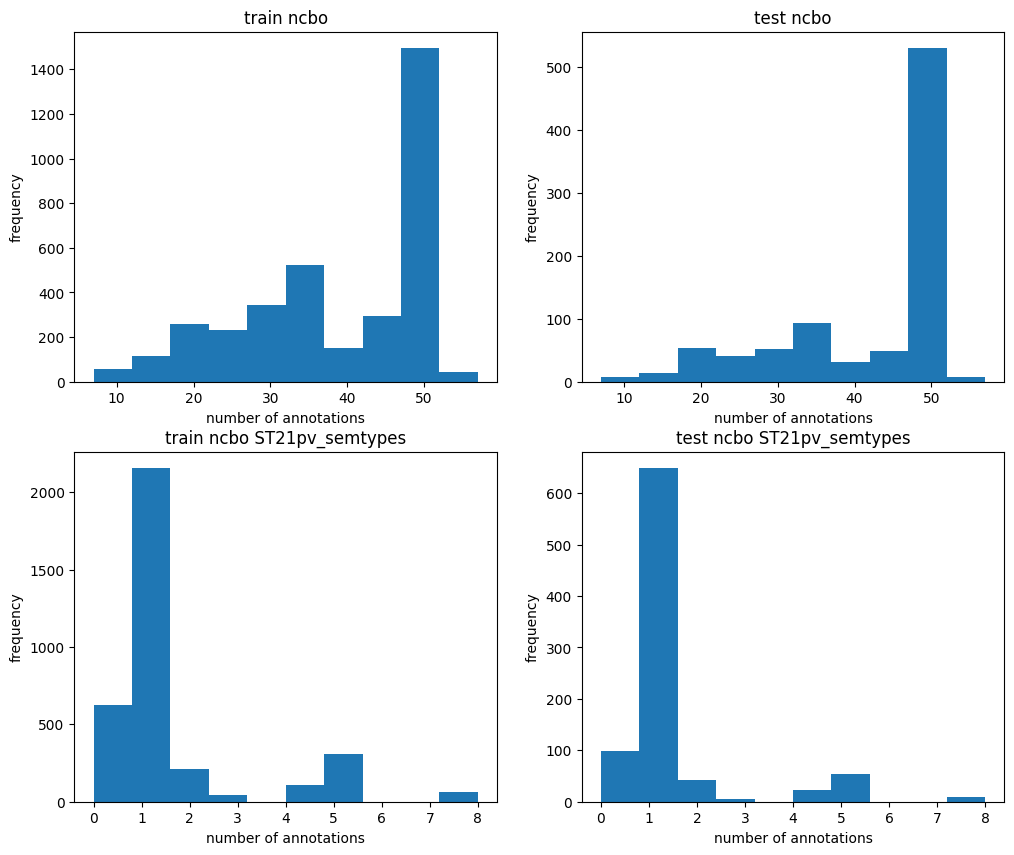

In [20]:
fig, axes = plt.subplots(2,2, figsize=(12, 10))

ax = axes[0,0]
plot_hist(axes[0,0], train_number_of_ncbo_annotations, "number of annotations", "frequency", "train ncbo")
plot_hist(axes[0,1], test_number_of_ncbo_annotations, "number of annotations", "frequency", "test ncbo")
plot_hist(axes[1,0], train_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "train ncbo ST21pv_semtypes")
plot_hist(axes[1,1], test_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "test ncbo ST21pv_semtypes")


## Extracting first order keywords-anotations matching

In [9]:
train_data = transform_strings_to_arrays(pd.read_csv('../results/bertopic_ncbo/bertopic_ncbo_nostopwords_data_2022-11-24_18-38-08_train.csv', index_col=0), col_names=['ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes'])
test_data = transform_strings_to_arrays(pd.read_csv('../results/bertopic_ncbo/bertopic_ncbo_nostopwords_data_2022-11-24_18-38-08_test.csv', index_col=0), col_names=['ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes'])

In [10]:
train_data

,PMID,text_to_annotate,ncbo_annotations,ncbo_annotations_ST21pv_semtypes
0,25763772,"isolates, infection, infections, transmission,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...
1,25847295,"coumarin, antioxidant, pfos, nonylphenol, diet...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...
2,26316050,"nanoparticles, nps, silk, films, coatings, sur...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...
3,26406200,"muscle, walking, exercise, gait, speed, standi...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...
4,26424709,"health, students, study, participants, mental,...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...
...,...,...,...,...
3508,28549399,"health, students, study, participants, mental,...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...
3509,28549760,"diabetes, obesity, intake, bmi, metabolic, adu...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...
3510,28550154,"nanoparticles, nps, silk, films, coatings, sur...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...
3511,28550348,"patients, study, cells, treatment, results, ex...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...


In [11]:
def create_annotation_pairs(sample_row, column_name):
    found_concepts = sample_row[column_name]
    res_ann_pairs= []
    for concept in found_concepts:

        max_trials = 5
        trials_no = 0
        while trials_no < max_trials:
            try:
                concept_class = get_json(concept["annotatedClass"]["links"]["self"])
                concept_class_ancestors = get_json(concept["annotatedClass"]['links']['ancestors'])
                break
            except:
                trials_no+=1
                continue
        if trials_no==max_trials:
            raise Exception("number of unsuccessfull connection attempts is max_trials")

        annotations = concept['annotations']

        # annotations for this class
        for annot in annotations:
            res_ann_pairs.append([annot['text'], concept_class["prefLabel"], 'DIRECT'])

        # annotations for ancestors
        for annot in annotations:
            for ancestor in concept_class_ancestors:
                res_ann_pairs.append([annot['text'], ancestor["prefLabel"], 'ANCESTOR'] )
      
    unique_ann_pairs = [list(x) for x in set(tuple(x) for x in res_ann_pairs)]
    return unique_ann_pairs
        

In [15]:
# TODO
train_data['ncbo_annotation_pairs'] = train_data.apply(create_annotation_pairs, column_name='ncbo_annotations', axis = 1)
test_data['ncbo_annotation_pairs'] = test_data.apply(create_annotation_pairs, column_name='ncbo_annotations', axis = 1)

In [ ]:
# TODO
train_data['ncbo_annotation_ST21pv_semtypes_pairs'] = train_data.apply(create_annotation_pairs, column_name='ncbo_annotations_ST21pv_semtypes', axis = 1)
test_data['ncbo_annotation_ST21pv_semtypes_pairs'] = test_data.apply(create_annotation_pairs, column_name='ncbo_annotations_ST21pv_semtypes', axis = 1)

### Annotation pairs example

In [12]:
examp_annot_pairs = train_data.iloc[0:2].apply(create_annotation_pairs, column_name='ncbo_annotations', axis = 1)

In [13]:
examp_annot_pairs[0]

[['TRANSMISSION', 'Transmission', 'DIRECT'],
 ['ANTIMICROBIAL', 'Anti-Infective Agent', 'ANCESTOR'],
 ['CPS', 'Research or Clinical Assessment Tool', 'ANCESTOR'],
 ['CPS', 'Immunohistochemical Status of PD-L1', 'ANCESTOR'],
 ['ANTIMICROBIAL', 'Drug, Food, Chemical or Biomedical Material', 'ANCESTOR'],
 ['CPS', 'Unit of Viscosity', 'ANCESTOR'],
 ['CPS', 'Diagnostic or Prognostic Test', 'ANCESTOR'],
 ['VIRUS', 'Virus', 'DIRECT'],
 ['INFECTION', 'Infectious Disorder', 'DIRECT'],
 ['CPS', 'Immunophenotypic Finding', 'ANCESTOR'],
 ['TRANSMISSION', 'Pathogenesis', 'ANCESTOR'],
 ['VIRUS', 'Physical Object', 'ANCESTOR'],
 ['INFECTION', 'Infection [Disease/Finding]', 'DIRECT'],
 ['INFECTION', 'Non-Neoplastic Disorder', 'ANCESTOR'],
 ['INFECTION', 'Non-Neoplastic Disorder by Special Category', 'ANCESTOR'],
 ['VIRUS', 'Organism', 'ANCESTOR'],
 ['CPS', 'Laboratory Test Result', 'ANCESTOR'],
 ['CPS', 'Finding', 'ANCESTOR'],
 ['STRAINS', 'Sprains and Strains', 'DIRECT'],
 ['INFECTION', 'Adverse Even